In [1]:
batch_size = 64
learning_rate = 0.001
patience = 3
epochs = 10

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
COLUMNS = ['id', 'filename', 'class', 'source']

train_df = pd.read_csv('/kaggle/input/covidx-cxr2/train.txt',sep=' ', names=COLUMNS)
# train_df = pd.get_dummies(train_df, columns=['class'])
train_df = train_df.drop(['id', 'source'], axis=1)

train_df.head()

,filename,class
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative


In [4]:
train_df, valid_df = train_test_split(
    train_df,
    train_size=0.9,
    stratify=train_df['class'],
    random_state=64
)

In [5]:
# train_df.loc[:, ['class_positive', 'class_negative']]

In [6]:
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    horizontal_flip=True,
    zoom_range=0.1,
)

train_data = train_data_generator.flow_from_dataframe(
    train_df,
    directory='/kaggle/input/covidx-cxr2/train',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    workers=-1
) 


valid_data = train_data_generator.flow_from_dataframe(
    valid_df,
    directory='/kaggle/input/covidx-cxr2/train',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    workers=-1
)

Found 26987 validated image filenames belonging to 2 classes.
Found 2999 validated image filenames belonging to 2 classes.


In [7]:
base_model = ResNet50V2(
    include_top=False,
    input_shape=(224,224,3)
)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(2, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

94668760/94668760 [==============================] - 4s 0us/step


In [8]:
callbacks = [
    ModelCheckpoint("covid-v2.h5", save_best_only=True),
    EarlyStopping(patience=patience, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
]

In [9]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
422/422 [==============================] - 1052s 2s/step - loss: 0.2025 - accuracy: 0.9230 - val_loss: 1.2260 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 2/10
422/422 [==============================] - 862s 2s/step - loss: 0.1353 - accuracy: 0.9503 - val_loss: 0.7278 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 3/10
422/422 [==============================] - 826s 2s/step - loss: 0.1187 - accuracy: 0.9567 - val_loss: 1.5319 - val_accuracy: 0.6032 - lr: 0.0010
Epoch 4/10
422/422 [==============================] - 785s 2s/step - loss: 0.0828 - accuracy: 0.9707 - val_loss: 0.1332 - val_accuracy: 0.9540 - lr: 5.0000e-04
Epoch 5/10
422/422 [==============================] - 824s 2s/step - loss: 0.0791 - accuracy: 0.9707 - val_loss: 0.0853 - val_accuracy: 0.9623 - lr: 5.0000e-04
Epoch 6/10
422/422 [==============================] - 791s 2s/step - loss: 0.0721 - accuracy: 0.9733 - val_loss: 0.2075 - val_accuracy: 0.9156 - lr: 5.0000e-04
Epoch 7/10
422/422 [==============================]

In [10]:
test_df = pd.read_csv('/kaggle/input/covidx-cxr2/test.txt',sep=' ', names=COLUMNS)
# test_df = pd.get_dummies(test_df, columns=['class'], dtype=np.int8)
test_df = test_df.drop(['id', 'source'], axis=1)
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_data = test_data_generator.flow_from_dataframe(
    test_df,
    directory='/kaggle/input/covidx-cxr2/test',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

Found 400 validated image filenames belonging to 2 classes.


In [11]:
results = model.evaluate(test_data)

7/7 [==============================] - 29s 4s/step - loss: 0.1176 - accuracy: 0.9650


In [12]:
model.save('covid-v2.h5')

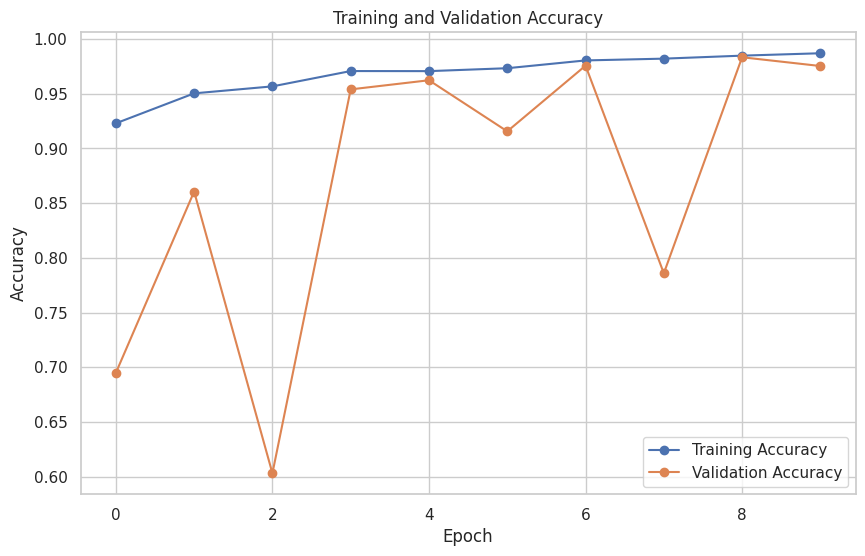

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o', linestyle='-')

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-')

# Set plot labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


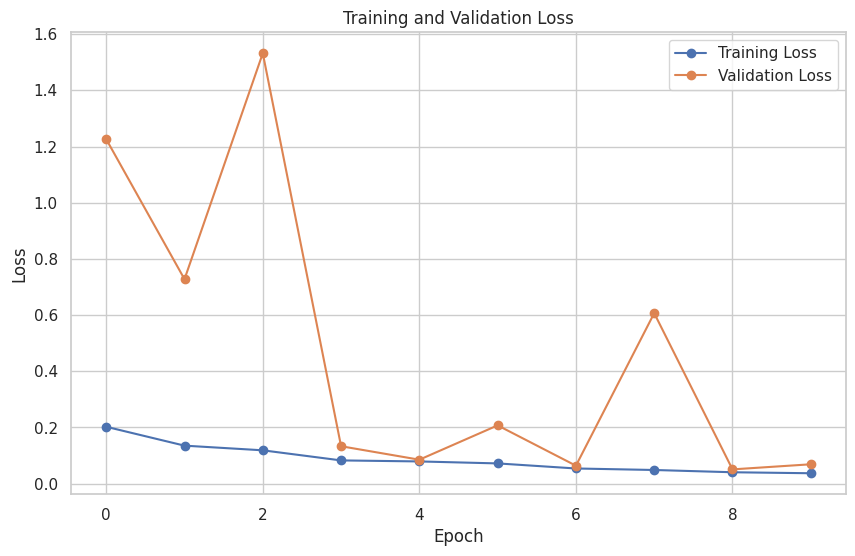

In [14]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot training accuracy
plt.plot(history.history['loss'], label='Training Loss', marker='o', linestyle='-')

# Plot validation accuracy
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='-')

# Set plot labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()